In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from urllib.parse import urlencode
import io
import urllib
import requests
import json
import pingouin as pg
%matplotlib inline

In [2]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/txn7q-CE2zSaPg'  # Сюда вписываете вашу ссылку

# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

# Загружаем файл и сохраняем его
download_response = requests.get(download_url)
file_content = download_response.content
string_data = file_content.decode('utf-8')
data_io = io.StringIO(string_data)
df = pd.read_csv(data_io)

In [3]:
df.head()

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1


In [4]:
df.count()

user_id_1    14514
user_id_2    14514
group        14514
is_match     14514
dtype: int64

Посчитаем конверсию каждой из групп.

In [5]:
df_fin = df.groupby('group', as_index = False).agg({'is_match' : 'count'}).rename(columns = {'is_match' : 'all_match'})
df_fin

,group,all_match
0,0,4792
1,1,9722


In [6]:
df_match = df.query('is_match == 1').groupby('group', as_index = False)\
    .agg({'is_match' : 'count'}).rename(columns = {'is_match' : 'is_match_ok'})
df_match

,group,is_match_ok
0,0,934
1,1,3909


In [7]:
df_fin = df_fin.merge(df_match, on = ('group'))
df_fin

,group,all_match,is_match_ok
0,0,4792,934
1,1,9722,3909


In [8]:
df_fin['conversion'] = df_fin.is_match_ok / df_fin.all_match

In [9]:
def highlight_column(s):
    color = 'yellow'  
    return ['background-color: %s' % color] * len(s)

df_fin_cr = df_fin.style.apply(highlight_column, subset=pd.IndexSlice[:, 'conversion'])
df_fin_cr

,group,all_match,is_match_ok,conversion
0,0,4792,934,0.194908
1,1,9722,3909,0.402078


<Axes: xlabel='group', ylabel='conversion'>

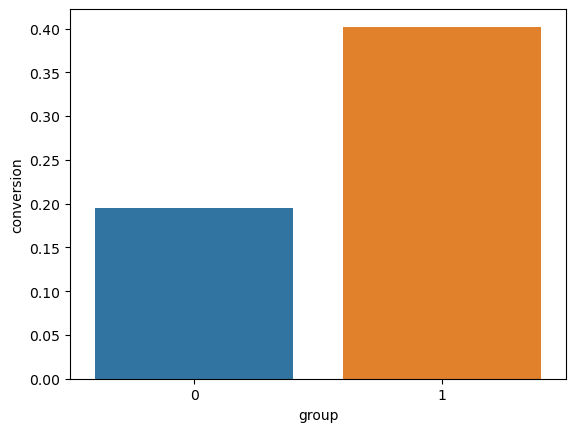

In [10]:
sns.barplot(data = df_fin, x = 'group', y= 'conversion')

Прекрасно видно, насколько конверсия первой(экспериментальной) группы больше, чем контрольной.
Теперь применим метод хи-квадрата, что бы доказать это статистически.

In [11]:
cross_tab = pd.crosstab(df['group'], df['is_match'])
cross_tab

is_match,0,1
group,,
0,3858,934
1,5813,3909


Нулевая гипотеза - взаимосвязи нет.
Альтернативная- взаимосвязь есть

In [12]:
stat, p, dof, expected = stats.chi2_contingency(cross_tab)
stat, p

(618.6889141576198, 1.4418299163662586e-136)

Статистика равна 618.6889141576198, что больше 12,5, а pValue = 1.4418299163662586e-136, что много меньше 0,05. Нулевую гипотезу отклоняем. Полученные результаты зависят от группы.

Посмотрим на количество активностей пользователей. Исследуем столбец user_id_1

In [13]:
df_user_id_1_1 = df.query('group == 1').groupby('user_id_1', as_index = False).agg({'is_match': 'count'})\
    .sort_values(by = 'is_match', ascending = False)
df_user_id_1_1

,user_id_1,is_match
82,170,29
21,38,28
407,827,28
99,198,27
404,819,26
...,...,...
189,380,12
320,649,12
365,744,12
35,79,11


In [14]:
df_user_id_1_0 = df.query('group == 0').groupby('user_id_1', as_index = False).agg({'is_match': 'count'}).sort_values(by = 'is_match', ascending = False)
df_user_id_1_0

,user_id_1,is_match
4,15,20
389,768,18
240,476,18
493,989,17
25,51,17
...,...,...
457,921,3
466,943,3
12,30,2
450,904,2


Text(0.5, 1.0, 'Распределение количества пользователей по количеству мэтчей')

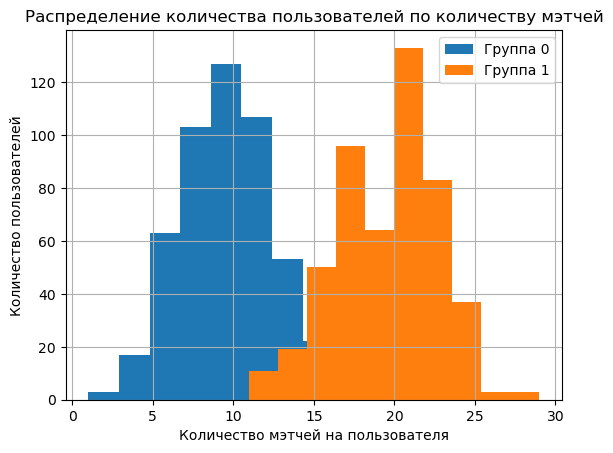

In [15]:
df_user_id_1_0.is_match.hist(label='Группа 0')
df_user_id_1_1.is_match.hist(label='Группа 1')
plt.legend()
plt.xlabel('Количество мэтчей на пользователя')
plt.ylabel('Количество пользователей')
plt.title('Распределение количества пользователей по количеству мэтчей')

In [16]:
stats.ttest_ind(df_user_id_1_0.is_match, df_user_id_1_1.is_match)

TtestResult(statistic=-51.85383774946492, pvalue=1.8942877064043142e-285, df=998.0)

Значение p-Value значительно меньше 0.05, а это значит мы можем отклонить гипотезу о равенстве средних 2-x выборок.
Посмотрим на столбцы user_id_2.

Text(0.5, 1.0, 'Распределение количества пользователей по количеству мэтчей')

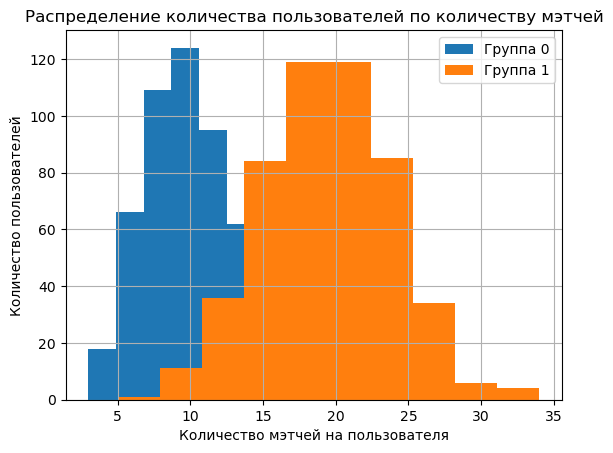

In [17]:
df_user_id_1_2 = df.query('group == 1').groupby('user_id_2', as_index = False).agg({'is_match': 'count'})\
    .sort_values(by = 'is_match', ascending = False)
df_user_id_0_2 = df.query('group == 0').groupby('user_id_2', as_index = False).agg({'is_match': 'count'})\
    .sort_values(by = 'is_match', ascending = False)
df_user_id_0_2.is_match.hist(label='Группа 0')
df_user_id_1_2.is_match.hist(label='Группа 1')
plt.legend()
plt.xlabel('Количество мэтчей на пользователя')
plt.ylabel('Количество пользователей')
plt.title('Распределение количества пользователей по количеству мэтчей')

In [18]:
stats.ttest_ind(df_user_id_0_2.is_match, df_user_id_1_2.is_match)

TtestResult(statistic=-40.04381401149136, pvalue=7.515112760079062e-210, df=998.0)

Аналогичная картина, как со столбцом user_id_1.  

**Вывод:** 
Новый алгоритм работает значительно лучше:  
- Конверсия *мэтчей* значительна лучше у нового алгоритма.
- Пользователи нового алгоритма более активные. 
